# Jupyter notebook to set up Mesa Range magnetic inversion 
This notebook prepares the input data and sets up the magnetic inversion for the academic inversion code JIF3D developed by Max Moorkamp et al. https://sourceforge.net/projects/jif3d/.

This notebook reads in magnetic measurements with the associated station heights, bedrock topography and Curie Point depths. The data is transferred into SI units except for the magnetic data. Additionally, this notebook prepares the inversion model (mesh) for the magnetic model with a 20 % padding around the measured input data. The prepared input data and inversion mesh’s are stored in NetCDF's files, which are used by JIF3D. Finally, this notebook creates a Linux shell script, which calls the inversion code and passes the required information of the NetCDF files.

#### jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 01/02/2024

#### Import python libariers

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from cmcrameri import cm
import cartopy.crs as ccrs
import os
from scipy.interpolate import griddata

##### set and create directory

In [2]:
# define gobal parameters
cmap_rev = cm.roma_r
cmap = cm.roma

# paths
Inversion_run = "Mesa_range_mag_inversion_only_250m_reg10"
# Create path if it does not exists
if not os.path.exists(Inversion_run):
    os.makedirs(Inversion_run)

inversion_path = Inversion_run + "/VI_inversion/"
# Create path if it does not exists
if not os.path.exists(inversion_path):
    os.makedirs(inversion_path)

#### Load data

In [3]:
Mag_data_pd = pd.read_csv(
    "DATA/Mag_alti_mensa_range_reso_500m.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "Mag", "Alti"],
)


Boundaries_mensa_range = pd.read_csv(
    "DATA/Boundaries_mensa_range_padding_reso_500m.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "bedrock", "CPC_above_Moho", "Moho_Pappa"],
)

#### Prepare input data

In [4]:
## Magnetic Data
mag_x = Mag_data_pd.x_ps
mag_y = Mag_data_pd.y_ps
mag_val = Mag_data_pd.Mag
mag_z = Mag_data_pd.Alti * -1  # model geometry is defined as postive = down

# set data error to 1 nT
mag_T_sigma = np.ones(mag_val.shape)

## Boundary condition (Topography, Curie Point Depths and Moho depth)
boundary_x = Boundaries_mensa_range.x_ps
boundary_y = Boundaries_mensa_range.y_ps
boundary_Topo = (
    Boundaries_mensa_range.bedrock * -1
)  # model geometry is defined as postive = down
boundary_CPD = Boundaries_mensa_range.CPC_above_Moho * 1000  # convert from km to m

print(
    "highest topo:",
    min(boundary_Topo),
    "m",
    "\n" "lowest topo:",
    max(boundary_Topo),
    "m",
    "\n",
)

highest topo: -3687 m 
lowest topo: 1207 m 



### Plotting input data

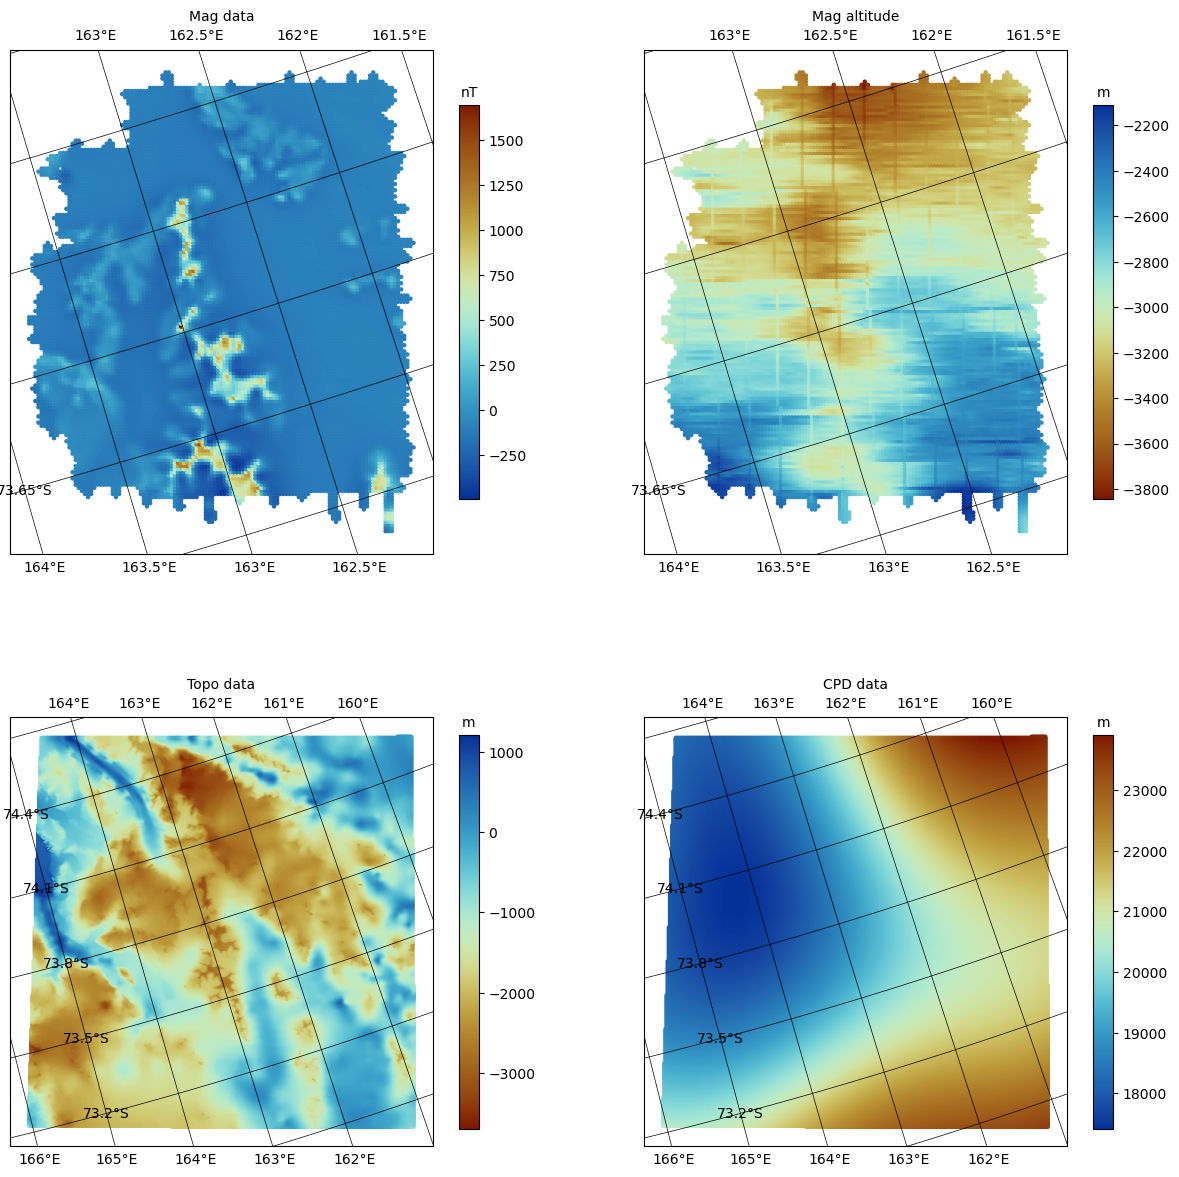

In [5]:
# create figure
figure1 = plt.figure(figsize=(15,15),facecolor='white')

# mag data
ax1 = plt.subplot(2, 2, 1 , projection=ccrs.SouthPolarStereo())
plt.title('Mag data',fontsize=10)
im1 = plt.scatter(mag_x , mag_y , 5 , c=mag_val , cmap = cmap_rev )
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=.75)
cb.ax.set_title("nT",fontsize=10)
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)

# mag alti
ax2 = plt.subplot(2, 2, 2 , projection=ccrs.SouthPolarStereo())
plt.title('Mag altitude',fontsize=10)
im2 = plt.scatter(mag_x , mag_y , 5 , c=mag_z , cmap = cmap)
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im2, shrink=.75)
cb.ax.set_title("m",fontsize=10)
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)

# Topo data
ax3 = plt.subplot(2, 2, 3 , projection=ccrs.SouthPolarStereo())
plt.title('Topo data',fontsize=10)
im3 = plt.scatter(boundary_x , boundary_y , 5 , c=boundary_Topo , cmap = cmap)
ax3.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im3, shrink=.75)
cb.ax.set_title("m",fontsize=10)
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)

# Curie Point depth
ax4 = plt.subplot(2, 2, 4 , projection=ccrs.SouthPolarStereo())
plt.title('CPD data',fontsize=10)
im4 = plt.scatter(boundary_x , boundary_y , 5 , c=boundary_CPD , cmap = cmap_rev)
ax4.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im4, shrink=.75)
cb.ax.set_title("m",fontsize=10)
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)



### create magnetic NetCDF input file:

In [6]:
# define name of the NetCDF file
mag_data_file = Dataset(inversion_path + "magdata.nc", "w")

# The number of stations within the bounds specified above
nstat = mag_x.size

# create a dimension with the corret number of stations
statdim = mag_data_file.createDimension("StationNumber", nstat)

## x coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasx = mag_data_file.createVariable("MeasPosX", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosX
vmeasx.units = "m"
# fill the variable
vmeasx[:] = mag_x

## y coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasy = mag_data_file.createVariable("MeasPosY", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosY
vmeasy.units = "m"
# fill the variable
vmeasy[:] = mag_y

## z coordinates (station height)
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasz = mag_data_file.createVariable("MeasPosZ", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosZ
vmeasz.units = "m"
# fill the variable
vmeasz[:] = mag_z

## BA gravity values
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vT = mag_data_file.createVariable("T", "f8", ("StationNumber"))
# set the units metadata entry for the variable Scalar_gravity
vT.units = "nT"
# fill the variable
vT[:] = mag_val

## BA gravity uncertainty value
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vdT = mag_data_file.createVariable("dT", "f8", ("StationNumber"))
# set the units metadata entry for the variable dGz
vdT.units = "nT"
# fill the variable
vdT[:] = mag_T_sigma

# close the file
mag_data_file.close()

### create inversion mesh:

In [7]:
### check inversion mesh extrensions
model_res = 250
data_extension_x = np.max(mag_x) - np.min(mag_x)
data_extension_y = np.max(mag_y) - np.min(mag_y)

# check number of core inversion cells
nx_ix = int(data_extension_x / model_res)
ny_ix = int(data_extension_y / model_res)

# calculate 20 procent padding around the meassured data points
padding_x = (data_extension_x * 20) / 100
padding_y = (data_extension_y * 20) / 100

# add padding range onto the model extention
model_extention_x = data_extension_x + (2 * padding_x)
model_extention_y = data_extension_y + (2 * padding_y)

print("nx:", nx_ix, "\n", "ny:", ny_ix, "\n")

nx: 248 
 ny: 296 



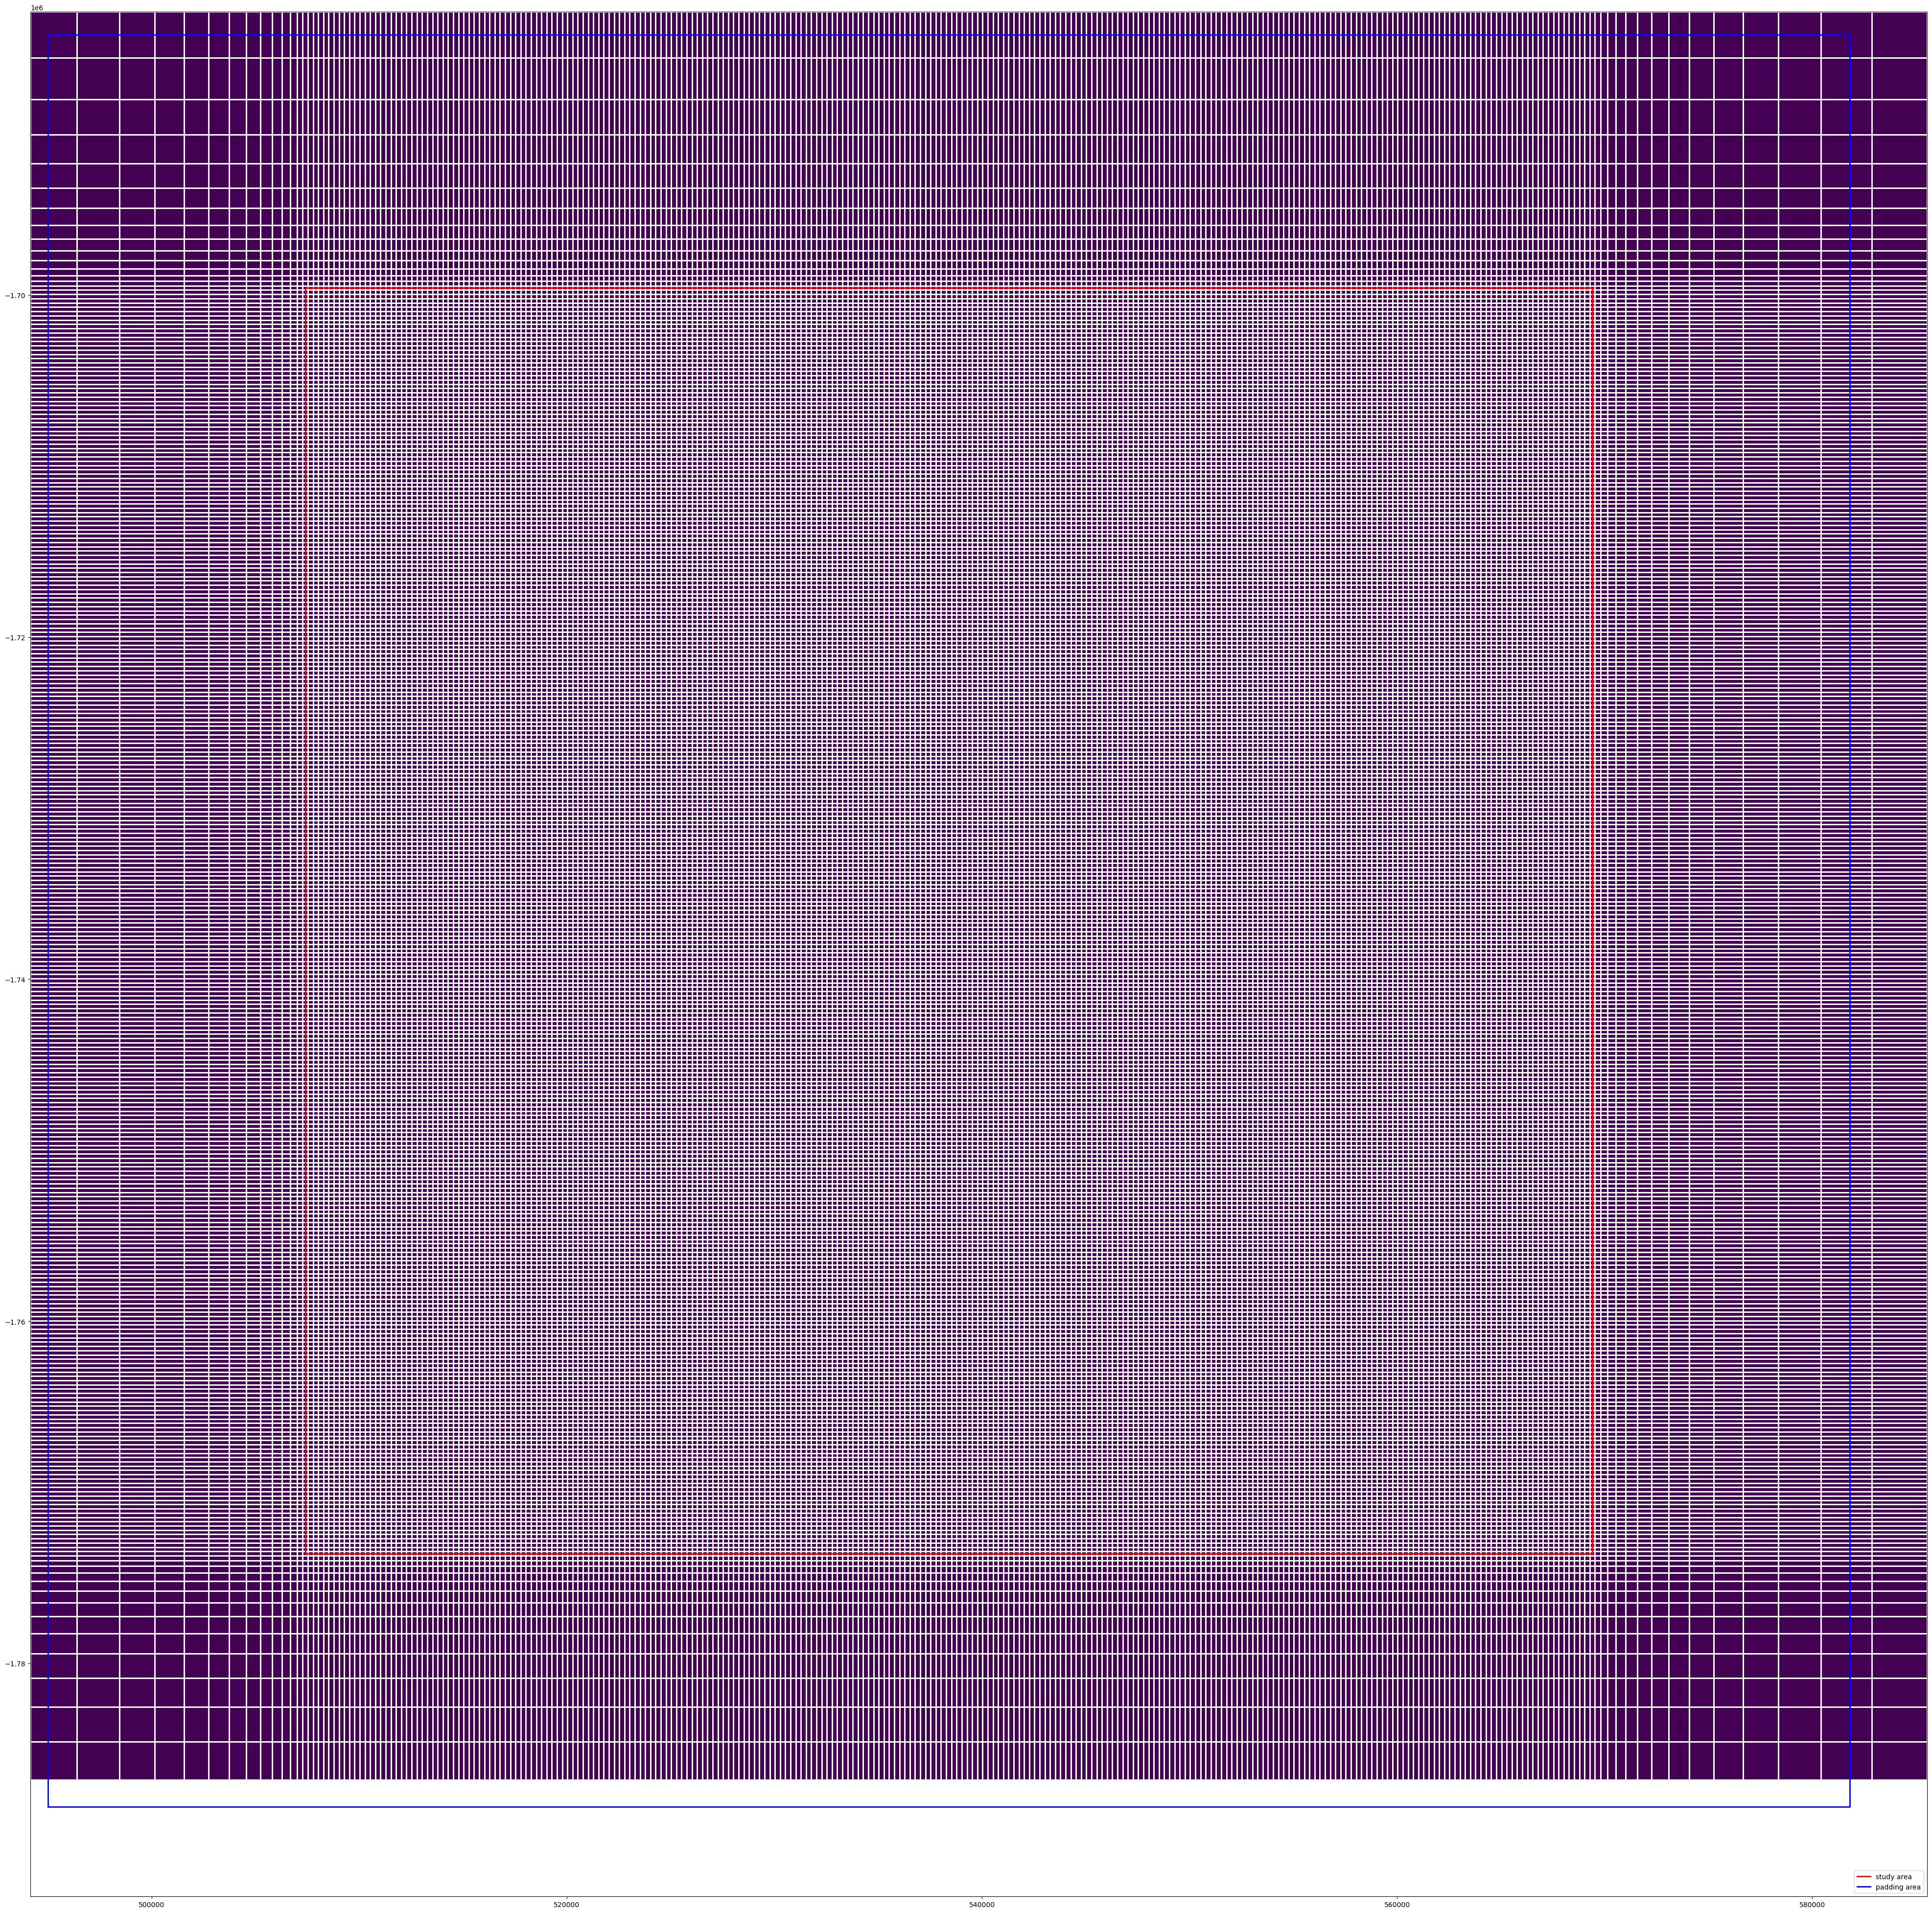

X-pad: [ 250.  300.  360.  432.  518.  622.  746.  896. 1075. 1290. 1548. 1858.
 2229. 2675.]
Y-pad: [ 250.  300.  360.  432.  518.  622.  746.  896. 1075. 1290. 1548. 1858.
 2229. 2675.]
X-center: 538404.438756447
Y-center: -1736582.79591434
X-Origin: 492605.43875644705
Y-Origin: -1788381.79591434
X_PS: [495280.43875645 497509.43875645 499367.43875645 500915.43875645
 502205.43875645 503280.43875645 504176.43875645 504922.43875645
 505544.43875645 506062.43875645 506494.43875645 506854.43875645
 507154.43875645 507404.43875645 507654.43875645 507904.43875645
 508154.43875645 508404.43875645 508654.43875645 508904.43875645
 509154.43875645 509404.43875645 509654.43875645 509904.43875645
 510154.43875645 510404.43875645 510654.43875645 510904.43875645
 511154.43875645 511404.43875645 511654.43875645 511904.43875645
 512154.43875645 512404.43875645 512654.43875645 512904.43875645
 513154.43875645 513404.43875645 513654.43875645 513904.43875645
 514154.43875645 514404.43875645 514654.4387

In [8]:
#set the total number of core cells in each direction
nx = nx_ix
ny = ny_ix
nz = 38

#how many horizontal padding cells do we want

padx = 14
pady = 14

# padx = added_padding_cells_x # 20 procent padding around the input data
# pady = added_padding_cells_y # 20 procent padding around the input data

#set the cell sizes in the core area in m, cells on the outside will grow
deltax = model_res
deltay = model_res
deltaz = 100

#the factor by which we increase layer thickness and size of padding cells
increasehor = 1.2
increasever = 1.1

#calculate the center position for the measurements
centerx = (np.min(mag_x) +  np.max(mag_x))/2.0
centery = (np.min(mag_y) + np.max(mag_y))/2.0

xpadspacing = np.round(deltax * np.power(increasehor,np.arange(0,padx)))
ypadspacing = np.round(deltay * np.power(increasehor,np.arange(0,pady)))
xpadwidth = np.sum(xpadspacing)
ypadwidth = np.sum(ypadspacing)

#calculate the model origin so the center of measurements is in the center of the model
startx = centerx - nx/2 * deltax - xpadwidth
starty = centery - ny/2 * deltay - ypadwidth
xpadbottom = startx + np.cumsum(xpadspacing[::-1])
ypadleft = starty + np.cumsum(ypadspacing[::-1])
xcore = xpadbottom[-1] + np.cumsum(np.ones(nx)*deltax)
ycore = ypadleft[-1] + np.cumsum(np.ones(ny)*deltay)
xpadtop = xcore[-1]  + np.cumsum(xpadspacing)
ypadright = ycore[-1]  + np.cumsum(ypadspacing)
X_PS = np.concatenate((xpadbottom, xcore, xpadtop))
Y_PS =  np.concatenate((ypadleft, ycore, ypadright))
#when we consider topography we have to set the origin of the mesh in z-direction to the highest topography
#also remember positive down, so above ground is negative
startz = -3700
#calculate the layer thicknesses with depth
#we round to full meters because
# a) it is a bit ridiculous to work with sub meter precision when inverting lithospheric structures
# b) we run into all kinds of floating point precision issues when trying to compare numbers
thick = np.round(deltaz * np.power(increasever,np.arange(0,nz)))
#calculate layer depth from thickness
Depth = startz + np.cumsum(thick)
#calculate cell bounbdaries in north direction from specified number of cells and cell size
Susceptibility = np.zeros([nz,ny+2*pady,nx+2*padx])
bg_Susceptibility = np.zeros(nz)
bg_Susceptibility = thick



xq, yq = np.meshgrid(X_PS,Y_PS , indexing='ij')

fig = plt.figure(figsize=(50,50))
plt.pcolormesh(xq,yq,np.transpose(Susceptibility[0,:,:]),edgecolors='white')
# define study area and padding area for plotting
x_study_area = [np.min(mag_x), np.max(mag_x), np.max(mag_x), np.min(mag_x) , np.min(mag_x)]
y_study_area = [np.min(mag_y), np.min(mag_y), np.max(mag_y), np.max(mag_y) , np.min(mag_y)]
plt.plot(x_study_area, y_study_area , 'r', linewidth=2 , label = 'study area')
x_padding_area = [np.min(mag_x)-padding_x, np.max(mag_x)+padding_x, np.max(mag_x)+padding_x, np.min(mag_x)-padding_x , np.min(mag_x)-padding_x]
y_padding_area = [np.min(mag_y)-padding_y, np.min(mag_y)-padding_y, np.max(mag_y)+padding_y, np.max(mag_y)+padding_y , np.min(mag_y)-padding_y]
plt.plot(x_padding_area, y_padding_area , 'blue', linewidth=2 , label = 'padding area')
plt.legend(loc='lower right')
# fig.savefig('Mensa_range_horizontal_increasing_mesh.png', format='png',dpi=500)

plt.show()
print ("X-pad:", xpadspacing)
print ("Y-pad:", ypadspacing)
print ("X-center:", centerx)
print ("Y-center:", centery)
print ("X-Origin:", startx)
print ("Y-Origin:", starty)
print("X_PS:", X_PS)
print("Y_PS:", Y_PS)
print("Thicknesses:", thick)
print("Depth", Depth)


In [9]:
model_mag = Dataset(inversion_path + "start_mag.nc", "w")
Grid_x_dim = model_mag.createDimension("Northing", X_PS.size)
Grid_y_dim = model_mag.createDimension("Easting", Y_PS.size)
Depthdim = model_mag.createDimension("Depth", Depth.size)
bgdim = model_mag.createDimension("bg_layers", bg_Susceptibility.size)

v_x_direction = model_mag.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_mag.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_mag.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_mag.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_mag.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_mag.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vsus = model_mag.createVariable(
    "Susceptibility", "f8", ("Depth", "Easting", "Northing")
)
vsus[:, :, :] = Susceptibility[:, :, :]
vsus.units = " "

model_mag.close()

In [10]:
# calculate the cell centers for our mesh
X_direction = np.append(startx, X_PS)
Y_direction = np.append(starty, Y_PS)
Z_direction = np.append(startz, Depth)
mp_x_direction = (X_direction[:-1] + X_direction[1:]) / 2.0  # mp = midpoint
mp_y_direction = (Y_direction[:-1] + Y_direction[1:]) / 2.0  # mp = midpoint
x_ps_grid, y_ps_grid = np.meshgrid(mp_x_direction, mp_y_direction, indexing="xy")

# perform a linear interpolation of the topography onto those cell centers
topointer = griddata(
    (boundary_x, boundary_y), boundary_Topo, (x_ps_grid, y_ps_grid), method="linear"
)
CPDinter = griddata(
    (boundary_x, boundary_y), boundary_CPD, (x_ps_grid, y_ps_grid), method="linear"
)

## plot model mesh (model setup)

In [11]:
profile_y = 65

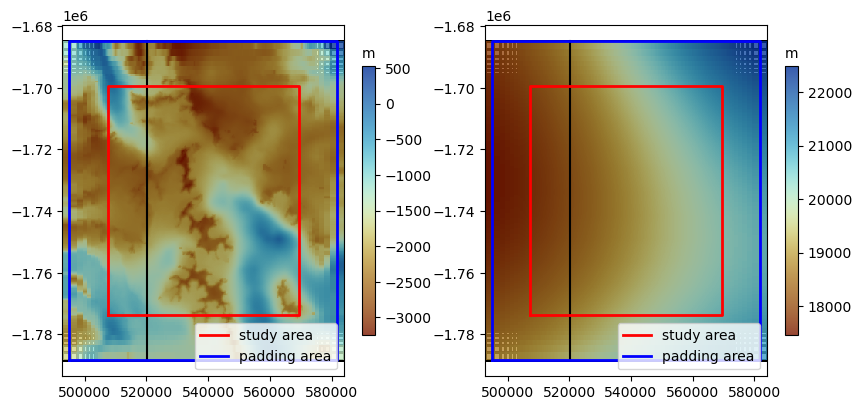

In [12]:
xv, yv = np.meshgrid(X_direction,Y_direction)
line_x = (xv[0,profile_y] , xv[0,profile_y])
line_y = (yv[0,profile_y] , yv[-1,profile_y])

#plot the resulting topography at the resolution of the mesh
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 2, 1)
plt.pcolormesh(x_ps_grid,y_ps_grid,Susceptibility[0,:,:], cmap='Greys',edgecolors='black',)
im1 = plt.pcolormesh(x_ps_grid,y_ps_grid,topointer , cmap = cmap, alpha=.8)
plt.plot(line_x,line_y, '-k')
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=.7)
cb.ax.set_title("m",fontsize=10)
plt.plot(x_study_area, y_study_area , 'red', linewidth=2 , label = 'study area')
plt.plot(x_padding_area, y_padding_area , 'blue', linewidth=2 , label = 'padding area')
plt.legend(loc='lower right')


ax3 = plt.subplot(1, 2, 2)
plt.pcolormesh(x_ps_grid,y_ps_grid,Susceptibility[0,:,:], cmap='Greys',edgecolors='black',)
im3 = plt.pcolormesh(x_ps_grid,y_ps_grid,CPDinter , cmap = cmap, alpha=.8)
plt.plot(line_x,line_y, '-k')
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im3, shrink=.7)
cb.ax.set_title("m",fontsize=10)
plt.plot(x_study_area, y_study_area , 'red', linewidth=2 , label = 'study area')
plt.plot(x_padding_area, y_padding_area , 'blue', linewidth=2 , label = 'padding area')
plt.legend(loc='lower right')

# # fig.savefig('Mensa_range_mesh_profile_y_location.png', format='png',dpi=500)


In [13]:
sus_cov = Susceptibility.copy()
# set the density values we want to assign to earth and air
cov_rock_cell = 1.0
cov_air_cell = 1e-10
below_CPD_cell = 1e-10

#go through each column of cells and assign air values to all cells above topography and earth values to those below
for i in range(0,X_PS.size):
    for j in range(0,Y_PS.size):
        sus_cov[np.nonzero(Depth < topointer[j,i]),j,i]  = cov_air_cell
        sus_cov[np.nonzero(Depth >= topointer[j,i]),j,i]  = cov_rock_cell
        sus_cov[np.nonzero(Depth >= CPDinter[j,i]),j,i]  = below_CPD_cell


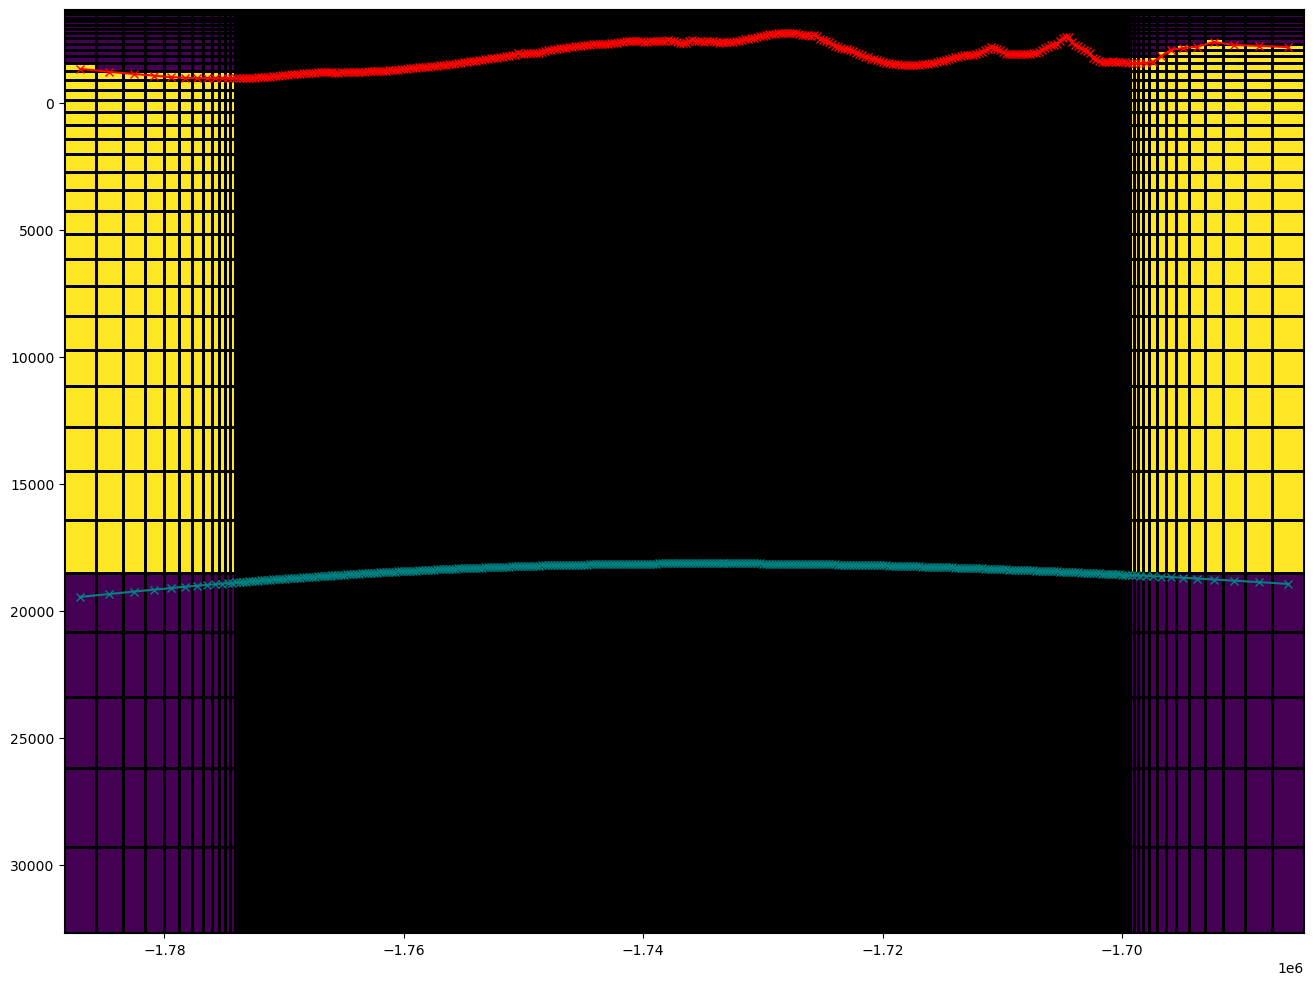

In [14]:
#plot an East-West profile through the resulting model
#also plot the interpolated topography to show how our model and the exact topography values differ
yi, zi = np.meshgrid(Y_direction,Z_direction)
fig = plt.figure(figsize=(16,12))
plt.pcolormesh(yi,zi,sus_cov[:,:,profile_y],edgecolors='black')
plt.plot(mp_y_direction,topointer[:,profile_y],marker='x' , c='red')
plt.plot(mp_y_direction,CPDinter[:,profile_y],marker='x', c='teal')

plt.gca().invert_yaxis()
# plt.ylim([1000,-4000])
plt.show()

# fig.savefig('Mensa_range_dens_mesh_profile_y_zoomed.png', format='png',dpi=500)


In [15]:
profile_x = 77

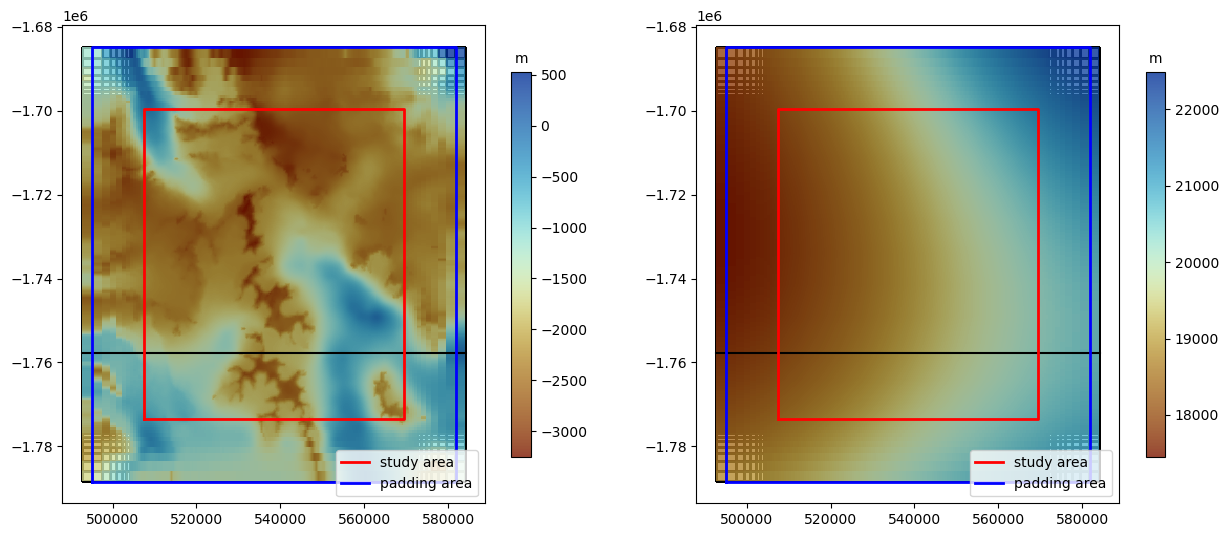

In [16]:
xv, yv = np.meshgrid(X_direction,Y_direction)
line_x = (xv[profile_x,0] , xv[profile_x,-1])
line_y = (yv[profile_x,0] , yv[profile_x,-1])

#plot the resulting topography at the resolution of the mesh
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1, 2, 1)
plt.pcolormesh(x_ps_grid,y_ps_grid,Susceptibility[0,:,:], cmap='Greys',edgecolors='black',)
im1 = plt.pcolormesh(x_ps_grid,y_ps_grid,topointer , cmap = cmap, alpha=.8)
plt.plot(line_x,line_y, '-k')
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=.5)
cb.ax.set_title("m",fontsize=10)
plt.plot(x_study_area, y_study_area , 'red', linewidth=2 , label = 'study area')
plt.plot(x_padding_area, y_padding_area , 'blue', linewidth=2 , label = 'padding area')
plt.legend(loc='lower right')


ax1 = plt.subplot(1, 2, 2)
plt.pcolormesh(x_ps_grid,y_ps_grid,Susceptibility[0,:,:], cmap='Greys',edgecolors='black',)
im1 = plt.pcolormesh(x_ps_grid,y_ps_grid,CPDinter , cmap = cmap, alpha=.8)
plt.plot(line_x,line_y, '-k')
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=.5)
cb.ax.set_title("m",fontsize=10)
plt.plot(x_study_area, y_study_area , 'red', linewidth=2 , label = 'study area')
plt.plot(x_padding_area, y_padding_area , 'blue', linewidth=2 , label = 'padding area')
plt.legend(loc='lower right')

# fig.savefig('Mensa_range_mesh_profile_x_location.png', format='png',dpi=500)


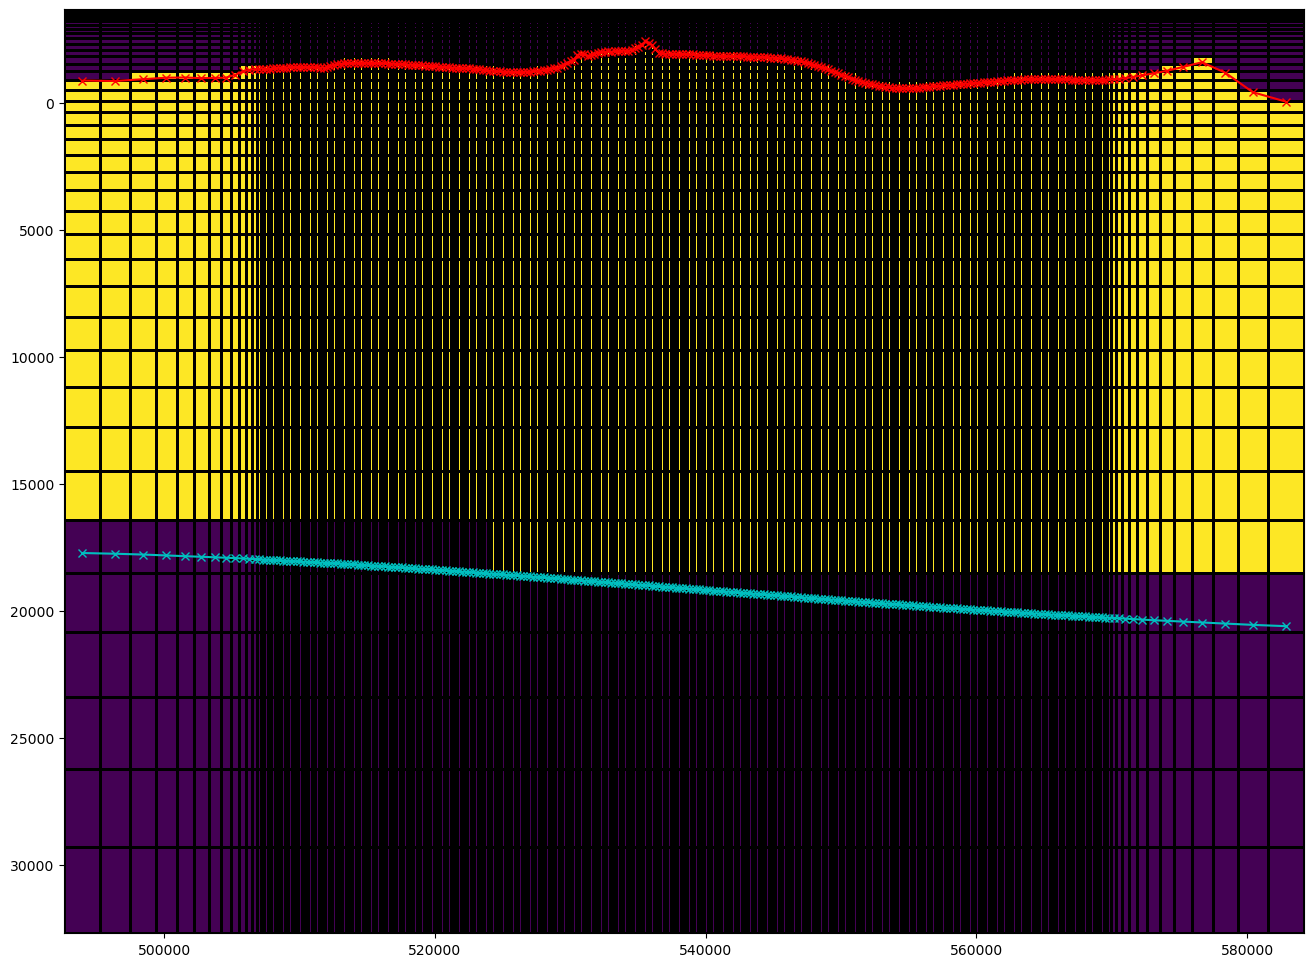

In [17]:
xi, zi = np.meshgrid(X_direction,Z_direction)
fig =plt.figure(figsize=(16,12))
plt.pcolormesh(xi,zi,sus_cov[:,profile_x,:],edgecolors='black')
plt.plot(mp_x_direction,topointer[profile_x,:],marker='x' , c='red')
plt.plot(mp_x_direction,CPDinter[profile_x,:],marker='x' , c='c')

plt.gca().invert_yaxis()
# plt.ylim([1000,-4000])
plt.show()
# fig.savefig('Mensa_range_sus_mesh_profile_x.png', format='png',dpi=500)


## build susceptibility covariance matrix (Susceptibility_cov)

In [18]:
model_sus_cov = Dataset(inversion_path + "Susceptibility_cov.nc", "w")
Grid_x_dim = model_sus_cov.createDimension("Northing", X_PS.size)
Grid_y_dim = model_sus_cov.createDimension("Easting", Y_PS.size)
Depthdim = model_sus_cov.createDimension("Depth", Depth.size)
bgdim = model_sus_cov.createDimension("bg_layers", bg_Susceptibility.size)

v_x_direction = model_sus_cov.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_sus_cov.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_sus_cov.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_sus_cov.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_sus_cov.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_sus_cov.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vsus = model_sus_cov.createVariable(
    "Susceptibility", "f8", ("Depth", "Easting", "Northing")
)
vsus[:, :, :] = sus_cov[:, :, :]
vsus.units = " "

model_sus_cov.close()

## Check the NetCDF files

In [19]:
import netCDF4 as nc4

## load mag data
mag_data_nc = nc4.Dataset(inversion_path + "magdata.nc")
XX_mag = mag_data_nc.variables["MeasPosX"][:]
YY_mag = mag_data_nc.variables["MeasPosY"][:]
mag_data = mag_data_nc.variables["T"][:]

## load mag mesh
mag_mesh_nc = nc4.Dataset(inversion_path + "start_mag.nc")
XX_sus_start_mesh = mag_mesh_nc.variables["Northing"][:]
YY_sus_start_mesh = mag_mesh_nc.variables["Easting"][:]
sus_start_mesh = mag_mesh_nc.variables["Susceptibility"][:]

# ## load sus cov mesh
sus_cov_mesh_nc = nc4.Dataset(inversion_path + "Susceptibility_cov.nc")
XX_sus_cov_mesh = sus_cov_mesh_nc.variables["Northing"][:]
YY_sus_cov_mesh = sus_cov_mesh_nc.variables["Easting"][:]
cov_sus = sus_cov_mesh_nc.variables["Susceptibility"][:]

mag_data_nc.close()
mag_mesh_nc.close()
sus_cov_mesh_nc.close()

In [20]:
xq_sus, yq_sus = np.meshgrid(XX_sus_start_mesh, YY_sus_start_mesh, indexing="xy")
xq_sus_cov, yq_sus_cov = np.meshgrid(XX_sus_cov_mesh, YY_sus_cov_mesh, indexing="xy")

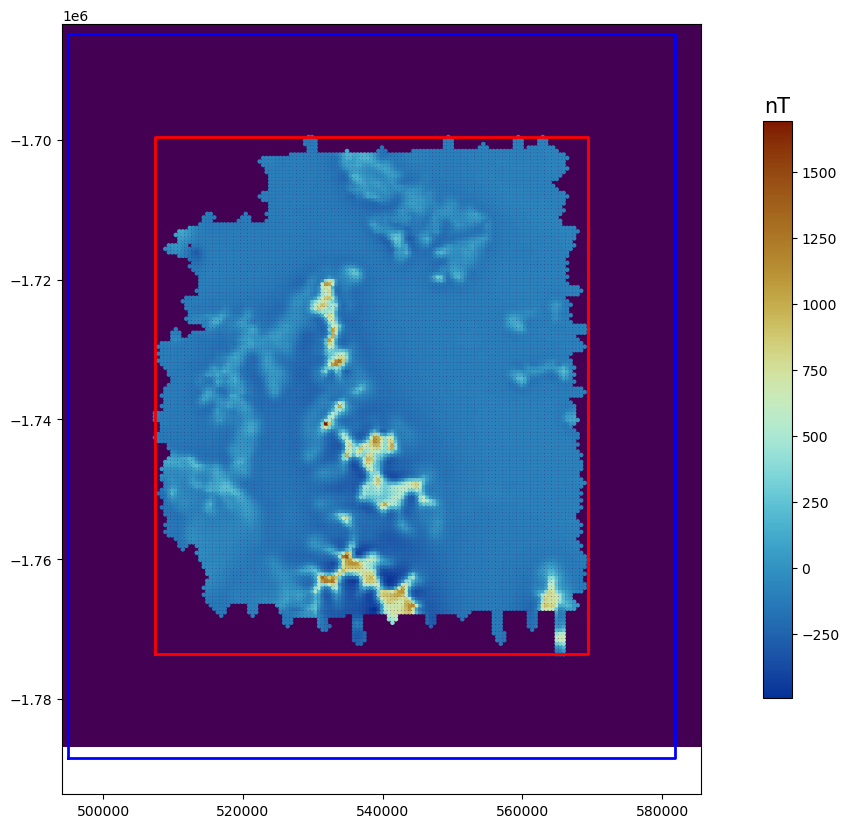

In [21]:
figure1 = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(1, 1, 1)
plt.pcolormesh(xq_sus_cov, yq_sus_cov, cov_sus[24, :, :])  # plotting
im = plt.scatter( XX_mag , YY_mag , 5 , c=mag_data , cmap=cmap_rev)
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im, shrink=0.75)
cb.ax.set_title("nT", fontsize=15)
plt.plot(x_study_area, y_study_area, "red", linewidth=2, label="study area")
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")

#### create run file

In [22]:
# location of the jif3D executables on your system
execpath = "../../../../bin/"
# program we want to run
progname = "jointinv"
options = " --inclination -1.4566 --declination 2.2756 --fieldstrength 64411.1740 --magminerr 10 --minsus -0.1 --maxsus 0.1  --sus_covmod Susceptibility_cov.nc"
# name of the density starting mesh
gravmesh = "start_grav.nc"
# name of the gravity data file
gravdata = "gravdata.nc"
# name of the susecptibility starting mesh
magmesh = "start_mag.nc"
# name of the magnetics data file
magdata = "magdata.nc"

## set data weights. 0 means no data

# gravity data
gravweight = 0.0
# FTG data
ftgweight = 0.0
# magnetic data
magweight = 1.0
magvectorweight = 0.0
mtweight = 0.0
DCResistivity = 0.0
tomographyweight = 0.0
surfacewaveweight = 0.0
# coupling term
coupling = 0
# density regularization
gravregularization = 1.0
# susceptibility regularization
magregularization = 1.0
# maximum number of iterations
iterations = 100.0

# write all information to file
f = open(inversion_path + "run", "w")
f.write(execpath + progname + options + " <<eof \n")
f.write(magmesh + "\n")
f.write(str(gravweight) + "\n")
f.write(str(ftgweight) + "\n")
f.write(gravdata + "\n")
f.write(gravmesh + "\n")
f.write(str(magweight) + "\n")
f.write(magdata + "\n")
f.write(magmesh + "\n")
f.write(str(magvectorweight) + "\n")
f.write(str(mtweight) + "\n")
f.write(str(DCResistivity) + "\n")
f.write(str(tomographyweight) + "\n")
f.write(str(surfacewaveweight) + "\n")
f.write(str(coupling) + "\n")
f.write(str(gravregularization) + "\n")
f.write(str(magregularization) + "\n")
f.write(str(iterations) + "\n")
f.write("eof\n")
f.close()